In [ ]:
# default_exp losses

# Losses

> Custom loss functions.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# export
import torch
import torch.nn.functional as F

from htools import add_docstring

In [ ]:
# Used for testing only.
from fastai.metrics import LabelSmoothingCrossEntropy
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn

from htools import assert_raises, InvalidArgumentError

In [ ]:
# export
def smooth_soft_labels(labels, alpha=.1):
    """Add uniform probability to a tensor of soft labels or 
    one-hot-encoded hard labels. Classes with zero probability
    will therefore end up with alpha/k probability, where k is
    the total number of classes. Note that some implementations
    may use alpha/(k-1), so if you notice a difference in output 
    that could be the source.
    
    Parameters
    ----------
    labels: torch.tensor
        Tensor of labels where each row is a sample and each column
        is a class. These can be one hot encodings or a vector of soft
        probabilities. Shape (batch_size, num_classes).
    alpha: float
        A positive value which will be used to assign nonzero 
        probabilities to the classes that are currently zeros. A larger
        alpha corresponds to a higher degree of smoothing (useful when
        accounting for noisier labels, trying to provide a stronger
        regularizing effect, or encouraging less confident predictions).
    """
    if alpha < 0:
        raise InvalidArgumentError('Alpha must be non-negative.')
    
    # Avoid unnecessary computation.
    if not alpha: 
        return labels
    length = labels.shape[-1]
    nonzeros = (labels > 0).sum(-1).unsqueeze(-1).float()
    return torch.clamp_min(labels - alpha/nonzeros, 0) + alpha/length

In [ ]:
# export
def soft_label_cross_entropy_with_logits(y_pred, y_true, alpha=0.0, 
                                         reduction='mean'):
    """Compute cross entropy with soft labels. PyTorch's built in 
    multiclass cross entropy functions require us to pass in integer
    indices, which doesn't allow for soft labels which are shaped like
    a one hot encoding. FastAI's label smoothing loss uniformly divides
    uncertainty over all classes, which again does not allow us to pass
    in our own soft labels.
    
    Parameters
    ----------
    y_pred: torch.FloatTensor
        Logits output by the model. 
        Shape (bs, num_classes).
    y_true: torch.FloatTensor
        Soft labels, where values are between 0 and 1. 
        Shape (bs, num_classes).
    alpha: float
        Label smoothing hyperparameter: a positive value which will be used to
        assign nonzero probabilities to the classes that are currently zeros. 
        A larger alpha corresponds to a higher degree of smoothing (useful when
        accounting for noisier labels, trying to provide a stronger
        regularizing effect, or encouraging less confident predictions).
    reduction: str
        One of ('mean', 'sum', 'none'). This determines how to reduce
        the output of the function, similar to most PyTorch
        loss functions.

    Returns
    -------
    torch.FloatTensor: If reduction is 'none', this will have shape
        (bs, ). If 'mean' or 'sum', this will be be a tensor with a 
        single value (no shape).
    """
    res = (-smooth_soft_labels(y_true, alpha) 
           * F.log_softmax(y_pred, dim=-1)).sum(-1)
    if reduction == 'none': return res
    return getattr(res, reduction)(0)

In [ ]:
# export
@add_docstring(soft_label_cross_entropy_with_logits)
def soft_label_cross_entropy(y_pred, y_true, alpha=0.0, reduction='mean'):
    """Same as `soft_label_cross_entropy_with_logits` but operates on
    softmax output instead of logits. The version with logits is 
    recommended for numerical stability. Below is the docstring for the logits 
    version. The only difference in this version is that y_pred will not be
    logits.
    """
    res = -smooth_soft_labels(y_true, alpha) * torch.log(y_pred)
    res = torch.where(torch.isnan(res) | torch.isinf(res),
                      torch.zeros_like(res), res).sum(-1)
    if reduction == 'none': return res
    return getattr(res, reduction)(0)

For demonstration, each row of our soft labels tries to capture a different case: 
- Row 0: High confidence label for one class, model has high confidence in the correct class.
- Row 1: Moderate confidence in 2 different classes, model has high confidence in the best class.
- Row 2: Confidence is split between a few classes, model predictions assign most probability to the two nonzero but non-ideal classes.

Row 2 should benefit slightly from label smoothing since it predicts answers that are not ideal but not entirely wrong.

In [ ]:
# 3 row mini batch
y_label = torch.tensor([0, 1, 3])
y_ohe = torch.tensor([[1, 0, 0, 0, 0],
                      [0, 1, 0, 0, 0], 
                      [0, 0, 0, 1, 0]], dtype=torch.float)
y_smooth = torch.tensor([[.9, .1, 0, 0, 0],
                         [.35, .65, 0, 0, 0],
                         [0, .1, .2, .7, 0]])
logits = torch.tensor([[6, 1, 3, 1, 2], 
                       [5, 8, 1, 1, 2],
                       [1, 3, 4, 2, 0]], dtype=torch.float)
y_hat = F.softmax(logits, dim=-1)
y_hat

tensor([[9.2457e-01, 6.2297e-03, 4.6032e-02, 6.2297e-03, 1.6934e-02],
        [4.7232e-02, 9.4869e-01, 8.6509e-04, 8.6509e-04, 2.3516e-03],
        [3.1685e-02, 2.3412e-01, 6.3641e-01, 8.6129e-02, 1.1656e-02]])

In [ ]:
# Test: smooth_soft_labels
assert torch.allclose(
    smooth_soft_labels(y_smooth, .1), 
    torch.tensor([[0.8700, 0.0700, 0.0200, 0.0200, 0.0200],
                  [0.3200, 0.6200, 0.0200, 0.0200, 0.0200],
                  [0.0200, 0.0867, 0.1867, 0.6867, 0.0200]]),
atol=1e-3), 'Case 1: alpha=0.1'

assert torch.allclose(smooth_soft_labels(y_smooth, 0.0), y_smooth, atol=1e-3),\
    'Case 2: alpha=0.0'

with assert_raises(InvalidArgumentError):
    smooth_soft_labels(y_smooth, -.1)

As expected, got InvalidArgumentError(Alpha must be non-negative.).


In [ ]:
modes = ('none', 'sum', 'mean')
for mode in modes:
    j = soft_label_cross_entropy_with_logits(logits, y_ohe, reduction=mode)
    print(f'reduction={mode}:', j)

reduction=none: tensor([0.0784, 0.0527, 2.4519])
reduction=sum: tensor(2.5830)
reduction=mean: tensor(0.8610)


In [ ]:
print('soft_label_cross_entropy_with_logits:\n' + '-'*37)
for mode in modes:
    j = soft_label_cross_entropy_with_logits(logits, y_smooth, reduction=mode)
    print(f'reduction={mode}:', j)

print('\nsoft_label_cross_entropy:\n' + '-'*25)
for mode in modes:
    j = soft_label_cross_entropy(y_hat, y_smooth, reduction=mode)
    print(f'reduction={mode}:', j)

soft_label_cross_entropy_with_logits:
-------------------------------------
reduction=none: tensor([0.5784, 1.1027, 1.9519])
reduction=sum: tensor(3.6330)
reduction=mean: tensor(1.2110)

soft_label_cross_entropy:
-------------------------
reduction=none: tensor([0.5784, 1.1027, 1.9519])
reduction=sum: tensor(3.6330)
reduction=mean: tensor(1.2110)


In [ ]:
for mode in modes:
    j = soft_label_cross_entropy_with_logits(logits, y_smooth, alpha=.2, 
                                             reduction=mode)
    print(f'reduction={mode}:', j)

reduction=none: tensor([0.7584, 1.7227, 2.1519])
reduction=sum: tensor(4.6330)
reduction=mean: tensor(1.5443)


In [ ]:
def plot_loss_by_alpha(y_pred, y_true, loss_func=None, loss_class=None):
    alphas = np.arange(0, 1, .05)
    
    if loss_class:
        js = {a: loss_class(a, 'none')(y_pred, y_true) for a in alphas}
    else:
        js = {a: loss_func(y_pred, y_true, a, 'none') for a in alphas}

    fig, ax = plt.subplots()
    for i in range(3):
        ax.plot(alphas, [x[i] for x in js.values()], label=i)
    plt.xlabel('Alpha (Smoothing Parameter)')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Notice the gap between row 2 begins to narrow, as predicted.

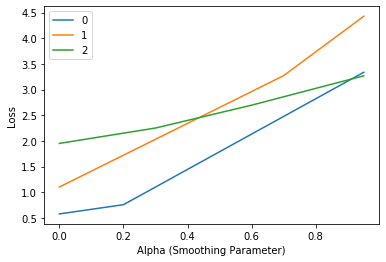

In [ ]:
plot_loss_by_alpha(y_hat, y_smooth, soft_label_cross_entropy)

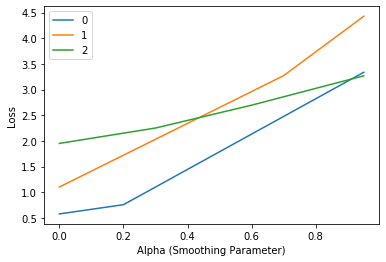

In [ ]:
plot_loss_by_alpha(logits, y_smooth, soft_label_cross_entropy_with_logits)

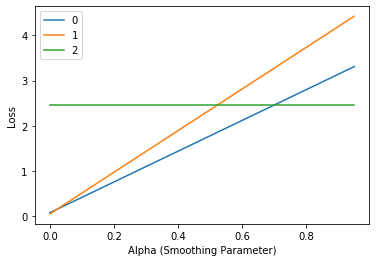

In [ ]:
plot_loss_by_alpha(logits, y_ohe, soft_label_cross_entropy_with_logits)

For comparison, here is the fastai label smoothing loss. It should return the same results in this case (just adding uniform noise). The advantage of ours is the ability to specify a prior non-uniform distribution.

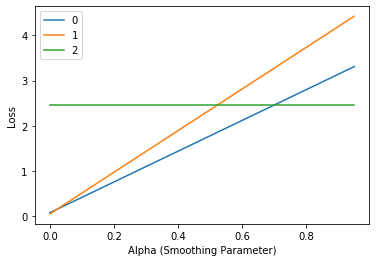

In [ ]:
plot_loss_by_alpha(logits, y_label, loss_class=LabelSmoothingCrossEntropy)

In [ ]:
def classification_mae_with_logits(y_pred, y_true, reduction='mean'):
    """Mean absolute error for classification using soft or one hot encoded
    labels (can be helpful for dealing with noisy labels). Classification
    models often forego the final softmax layer and use a loss function which
    computes the log softmax for numerical stability reasons. This loss 
    function makes it easy to swap different loss functions in and out without
    changing the model or the training loop.
    
    Parameters
    ----------
    y_pred: torch.FloatTensor
        Logits. Shape (bs, num_classes).
    y_true: torch.FloatTensor
        Labels, either one hot encoded or soft. Shape (bs, num_classes).
    reduction: str
        Just like any PyTorch loss function, this determines how to aggregate
        the loss over a mini batch. One of ('mean', 'sum', 'none').
    """
    # Built-in reduction will aggregate over every value in the tensor because
    # it expects that we're predicting a single value per sample. Because we're
    # predicting a vector for each sample, we compute row-wise sums regardless
    # of our choice of reduction, then aggregate over the batch dimension if
    # specified.
    rowwise_j = F.l1_loss(F.softmax(y_pred, dim=-1),
                          y_true, reduction='none').sum(-1)
    if reduction == 'none': return rowwise_j
    return getattr(rowwise_j, reduction)(dim=-1)

In [ ]:
logits

tensor([[6., 1., 3., 1., 2.],
        [5., 8., 1., 1., 2.],
        [1., 3., 4., 2., 0.]])

In [ ]:
F.softmax(logits, dim=-1)

tensor([[9.2457e-01, 6.2297e-03, 4.6032e-02, 6.2297e-03, 1.6934e-02],
        [4.7232e-02, 9.4869e-01, 8.6509e-04, 8.6509e-04, 2.3516e-03],
        [3.1685e-02, 2.3412e-01, 6.3641e-01, 8.6129e-02, 1.1656e-02]])

In [ ]:
y_ohe

tensor([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.]])

In [ ]:
for mode in modes:
    j = classification_mae_with_logits(logits, y_ohe, mode)
    print(mode, j) 

none tensor([0.1509, 0.1026, 1.8277])
sum tensor(2.0812)
mean tensor(0.6937)
